# K-Means Clustering: Make_blobs

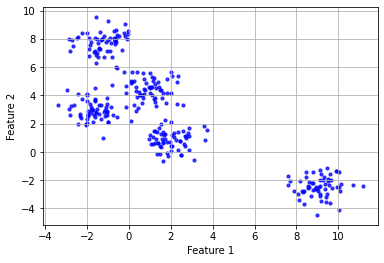

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import pairwise_distances

# Generate sample data
X, _ = make_blobs(n_samples=300, centers=5, cluster_std=0.70, random_state=0)

# Visualize the data
plt.scatter(X[:,0], X[:,1], c='b', s=10, alpha=0.75)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()
plt.show()

## Create K-Means class

In [2]:
class myKMeans:
    def __init__(self, k=2, tol=0.0001, max_iter=300, n_restarts=10):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        self.n_restarts = n_restarts

    def assign_clusters(self, X, centers):
        # Assign each data point to the closest centroid
        distances = np.sqrt(np.sum((X - centers[:, np.newaxis]) ** 2, axis=2))
        labels = np.argmin(distances, axis=0)
        return labels, distances

    def update_centers(self, X, labels, k):
        # Calculate new centroids
        return np.array([np.mean(X[labels == i], axis=0) for i in range(k)])

    def fit(self, X):

        self.X = X
        self.final_iter = 0
        min_inertia = np.Inf

        for _ in range(self.n_restarts):

            # Randomly select k data points as initial centroids
            centers = X[np.random.choice(X.shape[0], self.k, replace=False)]

            for i in range(self.max_iter):
                # Assign data points to clusters
                labels, dist = self.assign_clusters(X, centers)

                inertia = np.sum(np.min(dist ** 2, axis=0))

                # Update centroids
                new_centers = self.update_centers(X, labels, self.k)

                # Check for convergence
                if np.linalg.norm(centers - new_centers) < self.tol:
                    self.final_iter = i
                    break

                centers = new_centers

            if inertia < min_inertia:
                self.centers = centers
                self.labels = labels
                min_inertia = inertia

        self.inertia = min_inertia

    def silhouette(self):
        N = self.X.shape[0]
        a = []

        # Calculate cohesion values
        for i in range(self.k):
            d = pairwise_distances(self.X[self.labels == i,:])
            a.append(np.nanmean(np.where(d != 0, d, np.nan), axis=1))

        a = np.concatenate(a, axis=0)

        # Calculate separation values
        b = np.zeros(N) + np.inf
        for i in range(N):
            for j in range(self.k):
                if self.labels[i] != j:
                    b[i] = min(b[i], np.mean(pairwise_distances(self.X[i,:].reshape(1,-1),
                                                                self.X[self.labels == j,:])))

        sil = (b - a)/np.maximum(a, b)
        return sil

## Perform K-Means Clustering

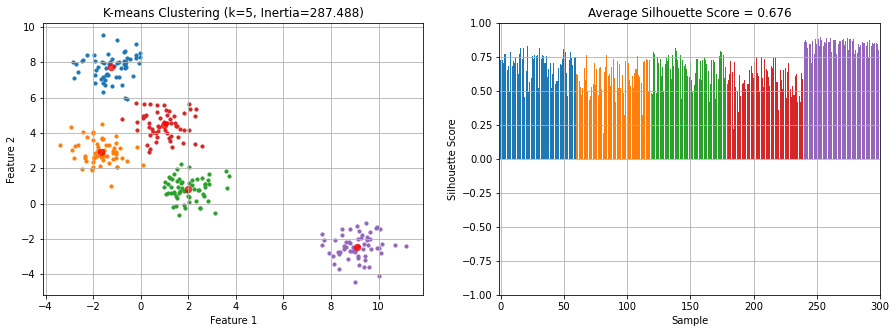

In [3]:
k = 5
KM = myKMeans(k=k)
KM.fit(X)

# Visualize clustered data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for i in range(k):
    ax1.scatter(X[KM.labels == i, 0], X[KM.labels == i, 1], s=10)

ax1.scatter(KM.centers[:, 0], KM.centers[:, 1], c='red', s=40, alpha=0.75)
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title(f"K-means Clustering (k={k}, Inertia={KM.inertia:.3f})")
ax1.grid()

silhouette_values = KM.silhouette()

sample = 0
for i in range(k):
    sil = silhouette_values[KM.labels == i]
    ax2.bar(np.arange(sample, sample + sil.size),sil)
    sample += sil.size

ax2.axis([-1, len(X), -1, 1])
ax2.set_xlabel('Sample')
ax2.set_ylabel('Silhouette Score')
ax2.set_title(f"Average Silhouette Score = {np.mean(silhouette_values):.3f}")
ax2.grid()

plt.show()

## Try different number of clusters, k=2, 3, ..., 10

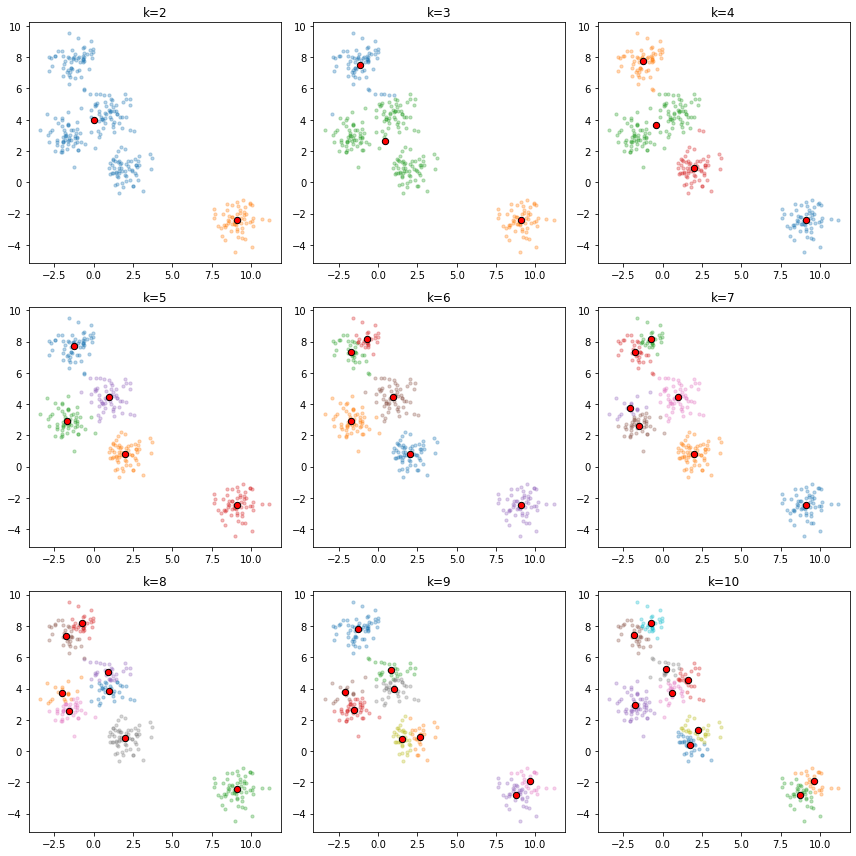

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(12,12))
ax = ax.flatten()

inertia_list = []

for k in range(9):

    # Perform K-means clustering
    KM = myKMeans(k=k+2)
    KM.fit(X)
    inertia_list.append(KM.inertia)

    # Visualize clustered data
    for i in range(k+2):
        ax[k].scatter(X[KM.labels == i, 0], X[KM.labels == i, 1], s=10, alpha=0.3)

    ax[k].scatter(KM.centers[:, 0], KM.centers[:, 1],
                  c='r', s=40, edgecolors='k')
    ax[k].set_title(f"k={k+2}")

plt.tight_layout()
plt.show()

## Plot inertia at different K

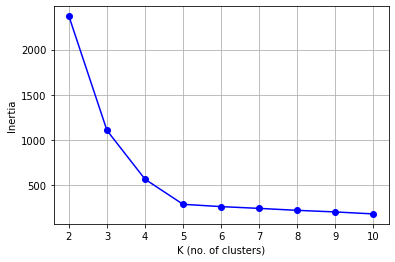

In [5]:
# Visualize the inertia at different K
plt.plot(np.arange(len(inertia_list))+2, inertia_list, 'bo-')
plt.xlabel('K (no. of clusters)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

## Compare with sklearn KMeans

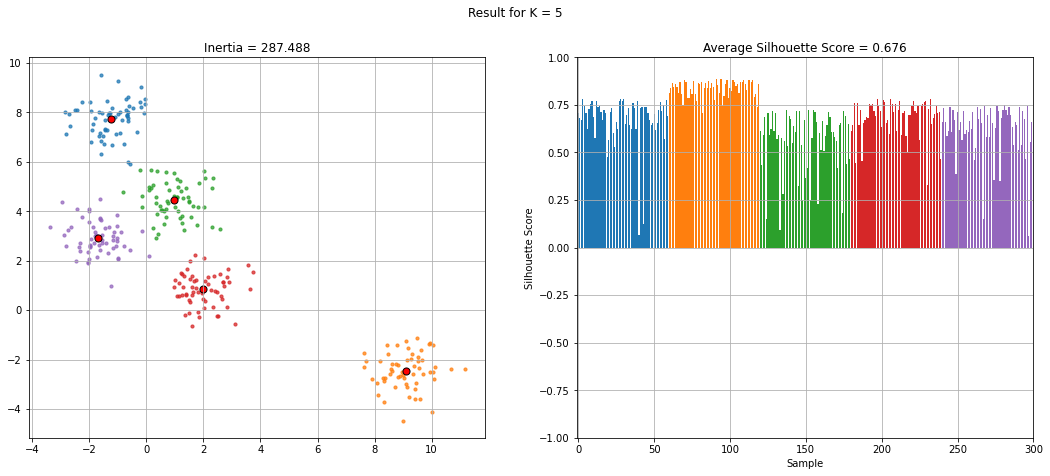

In [6]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

K = 5
kmeans = KMeans(n_clusters=K, n_init=10).fit(X)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_
silhouette_values = silhouette_samples(X, cluster_labels)
silhouette_avg = silhouette_score(X, cluster_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.set_size_inches(18, 7)
fig.suptitle(f"Result for K = {K}")
for i in range(0,K):
    ax1.scatter(X[cluster_labels == i,0], X[cluster_labels == i,1], 
                s=10, alpha=0.75)
ax1.scatter(centroids[:,0],centroids[:,1], s=50, color='r', edgecolor='k')
ax1.set_title(f"Inertia = {inertia:.3f}")
ax1.grid()
sample = 0
for i in range(0,K):
    sil = silhouette_values[cluster_labels == i]
    ax2.bar(np.arange(sample,sample + sil.size),sil)
    sample = sample + sil.size
ax2.axis([-1, len(X), -1, 1])
ax2.set_xlabel('Sample')
ax2.set_ylabel('Silhouette Score')
ax2.set_title(f"Average Silhouette Score = {silhouette_avg:.3f}")
plt.grid()
plt.show()